# Fractals and Dimension 3: Percolation

Continuing our exploration of fractal dimension, we'll look at how the fractal dimension goes through a phase change near the critical value of q in our Percolation model.

As usual, the first code block just imports the modules we will use.

In [64]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress
from scipy.signal import correlate2d

# Configure matplotlib's animation library to work in the browser.
matplotlib.rc('animation', html='jshtml')

### Percolation model
Here is the code we developed for exploring Percolation...

In [65]:
DEFAULT_IMSHOW_OPTIONS = dict(
    cmap = 'Blues',
    interpolation='none',
    origin='upper',
)

def plot_2D_array(array, axes=None, title='', **options):
    """ Plot the 2D array as an image on the given axes  1's will be dark blue, 0's will be light blue. """
    axes = axes or plt.gca()   # If not axes are provided, draw on current axes
    axes.set_title(title)
    axes.set_xticks([], [])  # remove axes tick marks
    axes.set_yticks([], [])
    options = {**DEFAULT_IMSHOW_OPTIONS, **options}
    axes.imshow(array, **options)


class Percolation:
    """ Percolation CA, representing a grid of porous and non-porous cells. """
    NONPOROUS = 0
    POROUS = 1
    WET = 5

    # Diffuse only to cardinal neighbours
    kernel = np.array([[0, 1, 0],
                       [1, 0, 1],
                       [0, 1, 0]])

    def __init__(self, n, q=0.5):
        """ Initializes nxn model with porous cells occurring with probability q
            n: number of rows / cols in the grid
            q: probability of a cell being porous
        """
        self.n = n
        self.q = q
        self.array = np.random.choice([self.POROUS, self.NONPOROUS], (n, n), p=[q, 1 - q])

        # fill the top row with wet cells
        self.array[0] = self.WET

    def step(self):
        """ Simulate one time step. """
        c = correlate2d(self.array, self.kernel, mode='same')
        wet = (self.array == self.POROUS) & (c >= self.WET)  # porous cells that have at least one wet neighbour
        self.array[wet] = self.WET

    def num_wet(self):
        """ Return a count of wet cells in the percolation cluster """
        return np.sum(self.array == self.WET)

    def bottom_row_wet(self):
        """Number of wet cells in the bottom row."""
        return np.sum(self.array[-1] == self.WET)

    def simulate(self):
        """
        Run percolation simulation until either water reaches bottom row or percolation stops
        Return a tuple, (percs, n_steps) True iff the models block percolates from top to bottom after n_steps
        """
        n_wet = [0, self.num_wet(), ]  # a list of # cells wet in each timestep.

        def still_percolating():
            """ Return true if model is still percolating, i.e. # wet at time t-1 > # wet at t-2 """
            return n_wet[-1] > n_wet[-2]

        while not self.bottom_row_wet() and still_percolating():
            self.step()
            n_wet.append(self.num_wet())

        return bool(self.bottom_row_wet()), len(n_wet) - 1

    def is_permeable(self):
        """
        Return True iff the models block percolates from top to bottom
        """
        return self.simulate()[0]

    def reset(self):
        """ Reset all WET cells back to permeable and wet the top row again. """
        self.array[self.array == self.WET] = self.POROUS
        self.array[0] = self.WET

    def draw(self, axes=None, step=''):
        """Draws the cells on given axes."""
        axes = axes or plt.gca()  # use current axes if none are provided.
        plot_2D_array(self.array, axes, cmap='Reds', title=f'Percolation {step}')

## Fractal Patterns in Percolation clusters?
Here are three percolation clusters at different values of $q$ near the critical value.

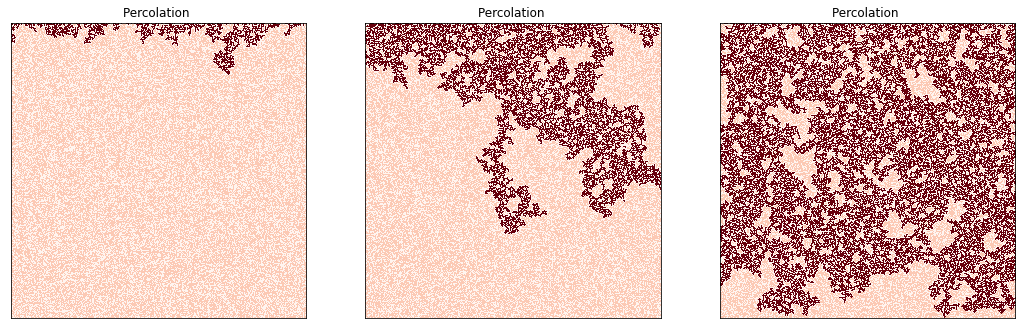

In [66]:
def percolate(n, q):
    """ Simulate and draw a percolation cluster of size n and prob. porous q """
    p = Percolation(n=n, q=q)
    p.simulate()
    p.draw()

qs = (0.57, 0.59, 0.61)
plt.subplots(figsize=(18, 6))

for plot, q in enumerate(qs):
    plt.subplot(1, 3, plot+1)
    percolate(n=300, q=q)

### Fractal Dimension of a Percolation Cluster

To estimate the fractal dimension of a percolation cluster, we'll measure how the number of wet cells scales with the size of a square "window" (a 2D slice).  We'll start with a 2x2 calibre window and grow it until it covers about 1/4 the grid.
At each window calibre, we count the number of cells that are $WET$ to see how wet cell counts scales with window calibre.

In [67]:
def sliding_window_count(array, calibre, target=Percolation.WET):
    """
    Tile the 2D array with a grid of square windows of given calibre,
     return number of windows in the grid that contain at least one target cell
    """
    rows,cols = array.shape
    grid = (array[i:i+calibre, j:j+calibre] for i in range(0, rows-calibre, calibre) for j in range(0, cols-calibre, calibre))
    return sum(target in window for window in grid)

n=100
q=0.6
perc = Percolation(n, q)
perc.simulate()

calibres =  [2, 10, 50]
counts = [sliding_window_count(perc.array, calibre) for calibre in calibres]
f'Wet cell counts by window calibre: {dict((cal, cnt) for cal,cnt in zip(calibres, counts))}'

'Wet cell counts by window calibre: {2: 1499, 10: 73, 50: 1}'

#### Plot the scaling behaviour

Simply plot the way wet cell counts scale as a function of the window size.

The slope of these lines gives an estimate of their dimension in the same way they did for the Koch Curve and 1D CA
A [linear regression](https://en.wikipedia.org/wiki/Linear_regression) estimates the slope (and other properties) of a line...

In [68]:
def log_slope(xs, ys):
    """ Estimate the slope of log-space plot of data points using linear regression """
    slope,*_ = linregress(np.log(xs), np.log(ys))
    return slope

def plot_scaling(perc):
    """
    Plot how the number of wet cells in the given perc model scales
    Compare this plot to 1D (y = x) and 2D (y = x**2) scaling factors
    """
    calibres = np.array(range(2, perc.n//2, 10))
    wet_counts = np.array([sliding_window_count(perc.array, calibre) for calibre in calibres])
    xs = perc.n / calibres  # xs are the number of grid squares so they scale in same direction as counts

    line_options = dict(linestyle='dashed', color='gray', alpha=0.7)
    plt.plot(xs, xs**2, label='2-D', **line_options)              # y =  x**2
    plt.plot(xs, wet_counts, '.', label=f'wet cells')             # y = 1 / wet cell count for window size x
    plt.plot(xs, xs, label='1-D', **line_options)                 # y = x

    title = f'Fractal Dimension: {log_slope(xs, wet_counts):0.2f}'
    plt.gca().set(title=title, xlabel='Grid Size', ylabel='# Wet Cells', xscale='log', yscale='log')
    plt.legend()

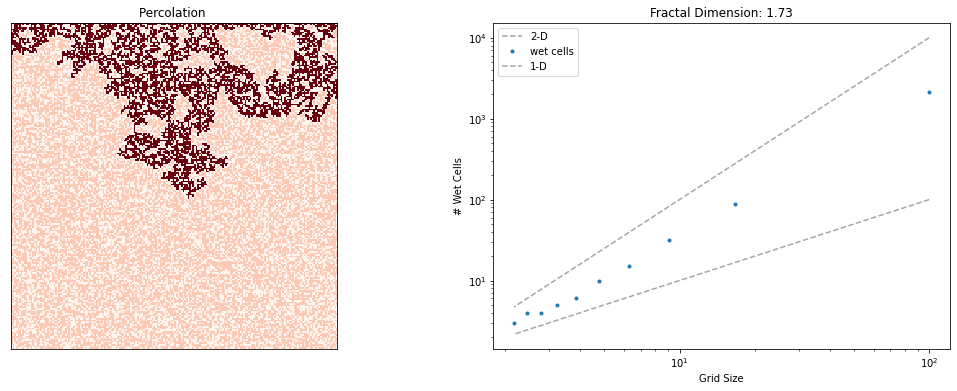

In [69]:
def scaling_experiment(n, q):
    """ Run an experiment to calculate and plot the fractal dimension of Percolation(n, q) """
    perc = Percolation(n, q)
    perc.simulate()

    plt.subplots(figsize=(18, 6))
    plt.subplot(1, 2, 1)
    perc.draw()
    plt.subplot(1, 2, 2)
    plot_scaling(perc)

# Critical value of q, q_crit ~= 0.59
n=200
q=0.58
scaling_experiment(n, q)

### How does fractal dimension change with $q$?

We could imagine that at low values of $q$, there are very few wet cells, and at high values nearly all cells are wet.

Does fractal dimension also show a phase change around the critical value of $q$?

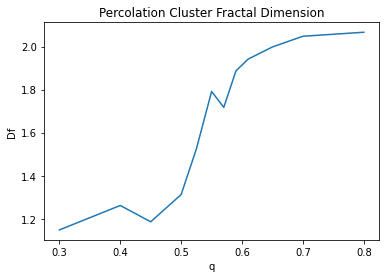

In [70]:
def fractal_dimensions_experiment(qs, n=100):
    """
    Plot how the fractal dimension of percolation clusters change for different values of q
    """
    calibres = np.array(range(2, n//2, 10))
    fractal_dimensions = []
    for q in qs:
        perc = Percolation(n, q)
        perc.simulate()
        wet_counts = np.array([sliding_window_count(perc.array, calibre) for calibre in calibres])
        xs = perc.n / calibres  # xs are the number of grid squares so counts scale in same direction

        fractal_dimensions.append( log_slope(xs, wet_counts) )
    return fractal_dimensions

n = 100
qs=[0.3, 0.4, 0.45, 0.5, 0.525, 0.55, 0.57, 0.59, 0.61, 0.65, 0.7, 0.8]
dims = fractal_dimensions_experiment(qs, n)
title = f'Percolation Cluster Fractal Dimension'
plt.gca().set(title=title, xlabel='q', ylabel='Df')
plt.plot(qs, dims)
plt.show()

### Epilogue: what just happend?
There does appear to be a **phase change** in the fractal dimension percolation blocks depending on their porosity, $q$
Interestingly, it does not appear as sharp as the phase change for permeability, and the critical value of $q$ appears to be different.
It looks like the phase change happens at around $q ~=0.55$ and is already approaching the upper asymptote by $q = 0.6$

#### Questions to ponder
 * why do you think the phase change from a 1D to 2D pattern is nearly done by the time $q$ reaches $0.6$?
 * how could we get a more accurate estimate for the critical value of $q$ where fractal dimension shows a phase change?
 * the model runs pretty fast - what happens as you increase the size of the percolation array?
 * how could you do some timing tests to measure the performace of this algorithm at different array sizes?